torch.Size([1801, 16, 16])


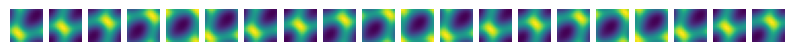

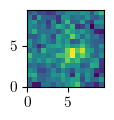

In [189]:
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 11
})

# SETTING = "low_data"
SETTING = "high_data"
assert SETTING in ["low_data", "high_data"]

d = torch.tensor( np.load("ks2d_long.npy") )
print(d.shape)

d_test = d[1600:-1,:,:]
if SETTING == "high_data": d_train = d[900:1200,:,:]
else: d_train = d[900:920,:,:]

L = 3 * np.pi
dt = 1
N_train = d_train.shape[0]
N_test = d_test.shape[0]
n = d.shape[1]
vmin = d.min()
vmax = d.max()

N_plots = 20
fig, ax = plt.subplots(1,N_plots,figsize=(10,2))
for j in range(N_plots):
    ax[j].imshow(d_train[int(N_train*(j/N_plots)),:,:].numpy())
    ax[j].set_axis_off()

plt.show()

fig, ax = plt.subplots(1, 1, figsize=(1,1))
d0 = torch.tensor( np.load("ks2d_initial.npy") )
d0 = d0[::d0.shape[0]//d.shape[1], ::d0.shape[1]//d.shape[2]]
ax.imshow(d0, extent=[0,L,0,L])

fig.savefig(f"plots/initial_data.pdf", bbox_inches='tight')
plt.show()

n_centers = 10
len G = 16
kernel shape = torch.Size([10, 10, 16])


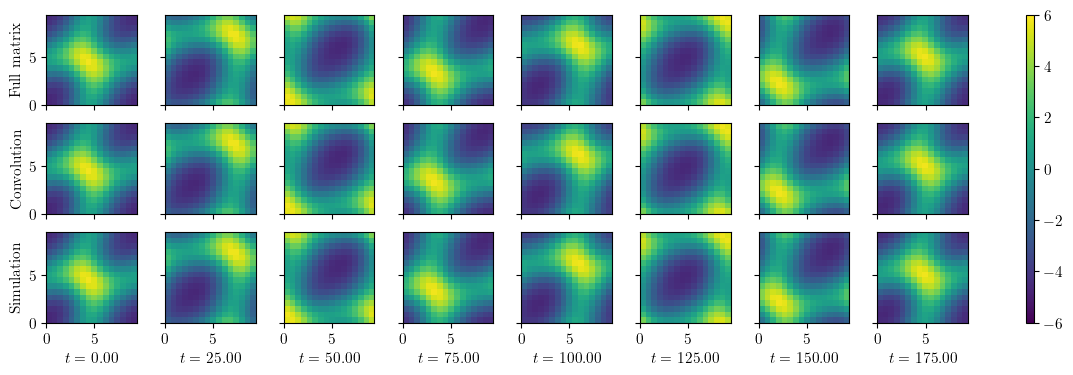

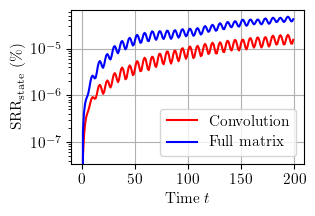

In [190]:
n_observations = 10
torch.manual_seed(0)
centers = torch.randint(low=0, high=n, size=(n_observations,2))

G0, G1 = 4, 4
G = [ (i,j) for i in range(G0) for j in range(G1) ]

def chi(x):
    return x[:,centers[:,0],centers[:,1]]
    # return torch.exp( 0.01 * x[:,0,0].view(-1,1) * torch.arange( 1, n_observations + 1 ).view(1,-1) )
    result = torch.exp(-0.5*((x.unsqueeze(1) - centers.unsqueeze(0))/bw).pow(2).sum(dim=[2,3]))
    return result

def psi(x, g=None):
    if g is not None: 
        x = torch.roll(x, -g[0]*round(n/G0), -2)
        x = torch.roll(x, -g[1]*round(n/G1), -1)
        return chi(x)
    else: 
        return torch.stack([psi(x,g) for g in G], dim=2).view(-1, n_observations * len(G))

def fourier(x):
    assert x.shape[-1] == len(G)
    b = x.shape[:-1]
    x = x.view(*b, G0, G1)
    x_hat = torch.fft.fft2(x)
    x_hat = x_hat.view(*b, len(G))
    return x_hat

def inv_fourier(x_hat):
    assert x_hat.shape[-1] == len(G)
    b = x_hat.shape[:-1]
    x_hat = x_hat.view(*b, G0, G1)
    x = torch.fft.ifft2(x_hat)
    x = x.view(*b, len(G))
    return x

def solve(X_in, X_out):
    X = psi(X_in)
    Y = psi(X_out)
    A = torch.linalg.solve(X.conj().T @ X + 1e-3*torch.eye(X.shape[1]), X.conj().T @ Y).T
    return A

def solve_fourier(X_in, X_out):
    b = X_in.shape[0]
    psi_X_hat = fourier( psi(X_in).view(b, n_observations, len(G)) )
    psi_Y_hat = fourier( psi(X_out).view(b, n_observations, len(G)) )
    A_hat = torch.zeros( (n_observations, n_observations, len(G) ), dtype=torch.complex128 )
    for rho_g in range(len(G)):
        X = psi_X_hat[:,:,rho_g]
        Y = psi_Y_hat[:,:,rho_g]
        A_hat[:,:,rho_g] = torch.linalg.solve(X.conj().T @ X + 1e-3*torch.eye(n_observations), X.conj().T @ Y).T
    A = inv_fourier(A_hat).real
    return A, A_hat

def solve_reconstruct(X_in):
    A = torch.linalg.lstsq(psi(X_in), X_in.view(-1, n**2), rcond=1e-9, driver="gelsd").solution.transpose(0,1)
    return A

def group_convolve(A, x):
    b = x.shape[0]
    x = x.view(b, n_observations, len(G))
    A = A.view(n_observations, n_observations, len(G))
    A_hat, x_hat = fourier(A), fourier(x)
    y_hat = torch.einsum("ijk,bjk -> bik", A_hat, x_hat)
    y = inv_fourier(y_hat)
    y = y.view(b, n_observations * len(G))
    return y


K = solve(d_train[:-1,...],d_train[1:,...])
B = solve_reconstruct(d)

print("n_centers =", n_observations)
print("len G =", len(G))

A, A_hat = solve_fourier(d_train[:-1,...],d_train[1:,...])
print("kernel shape =", A.shape)

N_plots = 8
fig, ax = plt.subplots(3, N_plots, figsize=(15, 4), sharex=True, sharey=True)
extent=[0,L,0,L]
vmin, vmax = -6, 6

xs_full = [  ]
xs_conv = [  ]
psis_d_test = psi(d_test)
psis_x_full = [ psis_d_test[0,...] ]
psis_x_conv = [ psis_d_test[0,...] ]

time = torch.arange(d_test.shape[0])*dt

for j in range(N_plots):
    steps = int( N_test / N_plots )
    for k in range(steps):
        xs_full.append( (B @ psis_x_full[-1]).view(n,n) )
        xs_conv.append( (B @ psis_x_conv[-1]).view(n,n) )
        psis_x_full += [ K @ psis_x_full[-1] ]
        psis_x_conv += [ group_convolve(A, psis_x_conv[-1][None,...])[0,...].real ]

    im0 = ax[0,j].imshow(xs_full[-steps].numpy(),extent=extent,vmin=vmin,vmax=vmax)
    im1 = ax[1,j].imshow(xs_conv[-steps].numpy(),extent=extent,vmin=vmin,vmax=vmax)
    im2 = ax[2,j].imshow(d_test[int(j*(N_test/N_plots)),:,:].numpy(),extent=extent,vmin=vmin,vmax=vmax)
    ax[2,j].set_xlabel(f"$t = {time[j*steps]:.2f}$")

psis_x_full = psis_x_full[:-1]
psis_x_conv = psis_x_conv[:-1]

ax[0,0].set_ylabel("Full matrix")
ax[1,0].set_ylabel("Convolution")
ax[2,0].set_ylabel("Simulation")
plt.colorbar(im0, ax=ax, aspect=40)

fig.savefig(f"plots/trajectories_{SETTING}.pdf", bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3,2))
psis_x_full = torch.stack(psis_x_full, dim=0)
psis_x_conv = torch.stack(psis_x_conv, dim=0)
err_full = (psis_x_full - psis_d_test).pow(2).mean(dim=1)
err_conv = (psis_x_conv - psis_d_test).pow(2).mean(dim=1)
divisor = psis_d_test.var(dim=1)
err_full_rel = 100 * err_full / divisor
err_conv_rel = 100 * err_conv / divisor
ax.plot(time, err_conv_rel, color="red", label="Convolution")
ax.plot(time, err_full_rel, color="blue", label="Full matrix")
ax.grid()
ax.legend()
ax.set_ylabel("$\\mathrm{SRR_{state}}$ $(\%)$")
ax.set_xlabel("Time $t$")

ax.set_yscale("log")

fig.savefig(f"plots/rmse_{SETTING}.pdf", bbox_inches='tight')
plt.show()

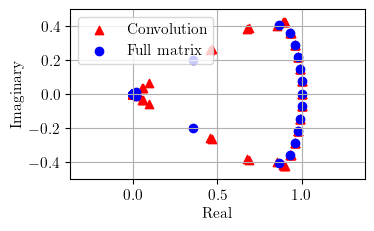

In [191]:
# computes eigenvectors and eigenvalues
def eig_convolution(A_hat):
    eigvals_A, eigvecs_A_hat = torch.linalg.eig( A_hat.permute(2, 0, 1) )
    eigvals_A = eigvals_A.permute(1,0).flatten()
    tmp = eigvecs_A_hat.permute(2,0,1) # (nr_evecs x |G_hat|) x dim_evecs
    eigvecs_A = torch.zeros(n_observations, len(G), n_observations, len(G), dtype=torch.complex128)
    for j in range(len(G)): eigvecs_A[:,j,:,j]  = tmp[:,j,:]
    eigvecs_A = inv_fourier(eigvecs_A)
    eigvecs_A = eigvecs_A.reshape(n_observations*len(G), n_observations*len(G)) # nr_evecs x dim_evecs
    eigvecs_A = eigvecs_A.transpose(0,1) # dim_evecs x nr_evecs
    eigvecs_A = eigvecs_A / eigvecs_A.abs().pow(2).sum(dim=0).pow(0.5) # normalize magnitude to 1
    return eigvals_A, eigvecs_A

eigvals_K, eigvecs_K = torch.linalg.eig(K)
eigvals_A, eigvecs_A = eig_convolution(A_hat)

# filter largest eigenvalues
# eigvals_A_largest = eigvals_A[ eigvals_A.abs() > 0.995 ]
# eigvals_K_largest = eigvals_K[ eigvals_K.abs() > 0.995 ]

fig, ax = plt.subplots(1, 1, figsize=(3.8,2.2) ) # , width_ratios=[0.5,0.5], sharey=True)
ax.grid()
ax.scatter(eigvals_A.real, eigvals_A.imag, marker="^", color="red", alpha=1, label="Convolution")
ax.scatter(eigvals_K.real, eigvals_K.imag, marker="o", color="blue", alpha=1, label="Full matrix")
ax.axis("equal")
ax.set_ylim([-0.5, 0.5])
ax.set_xlabel("Real")
ax.set_ylabel("Imaginary")
ax.legend(loc="upper left")
# ax[1].grid()
# ax[1].axis("equal")
# ax[1].set_ylim([-1.1, 1.1])
# ax[1].scatter(eigvals_A_largest.real, eigvals_A_largest.imag, marker=".", label="Convolution")
# ax[1].scatter(eigvals_K_largest.real, eigvals_K_largest.imag, marker="+", label="Full matrix")
# ax[1].legend(ncol=1, loc="upper left", bbox_to_anchor=(1.0, 1.0))
# ax[1].set_xlabel("Real")

fig.savefig(f"plots/evs_{SETTING}.pdf", bbox_inches='tight')
plt.show()

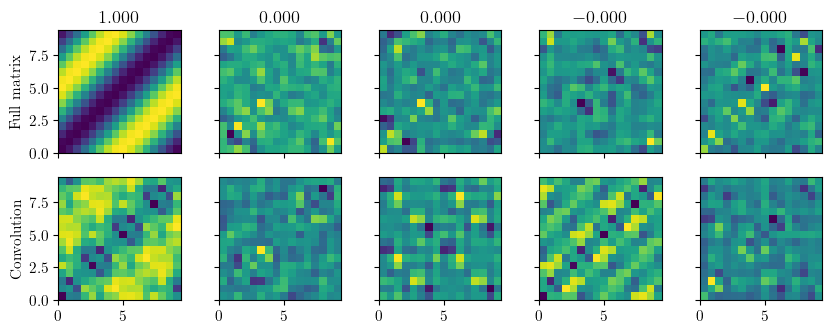

In [192]:
# computes matching eigenvalues
pairs_close = (eigvals_K.reshape(-1, 1) - eigvals_A.reshape(1, -1)).abs() < 1e-6
pairs_positive_imag = (0.5*eigvals_K.reshape(-1, 1) + 0.5*eigvals_A.reshape(1, -1)).imag >= 0
pairs = pairs_close & pairs_positive_imag

nnz = pairs.nonzero()
eigvals_selected = eigvals_A[nnz[:,1]]
eigvecs_K_selected = eigvecs_K[:,nnz[:,0]]
eigvecs_A_selected = eigvecs_A[:,nnz[:,1]]

# sorting
sorted_indices = torch.argsort(eigvals_selected.real, descending=True)
eigvals_selected = eigvals_selected[sorted_indices]
eigvecs_A_selected = eigvecs_A_selected[:,sorted_indices]
eigvecs_K_selected = eigvecs_K_selected[:,sorted_indices]

n_plots = 5
steps = int( eigvals_selected.shape[0] / n_plots )
eigvals_selected = eigvals_selected[::steps]
eigvecs_A_selected = eigvecs_A_selected[:,::steps]
eigvecs_K_selected = eigvecs_K_selected[:,::steps]

projected_K = B.to(torch.complex128) @ eigvecs_K_selected
projected_K = projected_K.reshape(n, n, -1)

projected_A = B.to(torch.complex128) @ eigvecs_A_selected
projected_A = projected_A.reshape(n, n, -1)

fig, ax = plt.subplots(2, n_plots, figsize=(10,3.5), sharey=True, sharex=True)

for j in range(n_plots):

    evec_K = projected_K[:,:,j]
    evec_A = projected_A[:,:,j]

    # choose sign
    dist_neg = (evec_K-evec_A).abs().pow(2).sum()
    dist_pos = (evec_K+evec_A).abs().pow(2).sum()
    if dist_neg > dist_pos: evec_A = -evec_A

    ax[0,j].imshow(evec_K.real, extent=extent) # , vmin=-0.005, vmax=0.005)
    ax[1,j].imshow(evec_A.real, extent=extent) # , vmin=-0.005, vmax=0.005)

    real, imag = eigvals_selected[j].real, eigvals_selected[j].imag
    if abs(imag) < 1e-5: ax[0,j].set_title(f"${real:.3f}$")
    elif imag > 0: ax[0,j].set_title(f"${real:.3f} + \\mathrm i{imag.abs():.3f}$")
    elif imag < 0: ax[0,j].set_title(f"${real:.3f} - \\mathrm i{imag.abs():.3f}$")

ax[0,0].set_ylabel("Full matrix")
ax[1,0].set_ylabel("Convolution")


plt.show()

In [193]:
# sanity check
evec = eigvecs_A[None,:,10]
eval = eigvals_A[10]
print( torch.allclose( eval * evec, group_convolve(A, evec) ) )
evec = eigvecs_K[:,10]
eval = eigvals_K[10]
print( torch.allclose( eval * evec, K.to(torch.complex128) @ evec ) )

True
True


In [194]:
# Todo: computation of Koopman eigenfunctions....
# here I have to compute left eigenvectors............
# a left eigenvector of a matrix is the same as a right eigenvector of its conjugate transpose....
# for convolution kernels, we need to transpose the (S,S)-part and invert the G-part
def transpose_kernel(A):
    A_left = A.transpose(0,1)
    A_left = A_left.view(n_observations, n_observations, G0, G1)
    A_left = A_left.flip(dims=[2,3])
    A_left = A_left.roll([1,1], dims=[2,3]) # inverts group element
    A_left = A_left.view(n_observations, n_observations, len(G))
    return A_left

eigvals_AT, eigvecs_AT = eig_convolution(fourier(transpose_kernel(A)))
eigvals_KT, eigvecs_KT = torch.linalg.eig(K.transpose(0,1))

# eigvecs_AT = eigvecs_AT[:,eigvals_AT.abs()>0.8]
# eigvals_AT = eigvals_AT[eigvals_AT.abs()>0.8]
# eigvecs_KT = eigvecs_KT[:,eigvals_KT.abs()>0.8]
# eigvals_KT = eigvals_KT[eigvals_KT.abs()>0.8]

# computes matching eigenvalues
# pairs_close = (eigvals_KT.reshape(-1, 1) - eigvals_AT.reshape(1, -1)).abs() < 1e-6
# pairs_positive_imag = (0.5*eigvals_KT.reshape(-1, 1) + 0.5*eigvals_AT.reshape(1, -1)).imag >= 0
# pairs = pairs_close & pairs_positive_imag
# 
# nnz = pairs.nonzero()
# eigvals_selected = eigvals_AT[nnz[:,1]]
# eigvecs_KT_selected = eigvecs_KT[:,nnz[:,0]]
# eigvecs_AT_selected = eigvecs_AT[:,nnz[:,1]]
# 
# # sorting
# sorted_indices = torch.argsort(eigvals_selected.real, descending=True)
# eigvals_selected = eigvals_selected[sorted_indices]
# eigvecs_AT_selected = eigvecs_AT_selected[:,sorted_indices]
# eigvecs_KT_selected = eigvecs_KT_selected[:,sorted_indices]

# print(eigvecs_left_A.abs().pow(2).sum(dim=0).pow(0.5))
# print(eigvecs_left_K.abs().pow(2).sum(dim=0).pow(0.5))


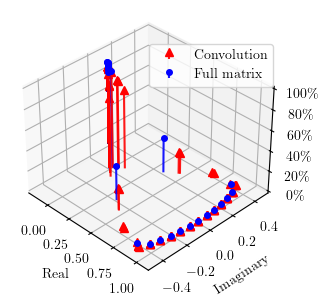

In [195]:
from matplotlib import ticker

# j = 10

# eigfunc_vals_K = psi(d_test[:M,:]).to(torch.complex128) @ eigvecs_KT
# evolution_predicted_K = eigvals_KT.view(-1,1).pow(torch.arange(M).view(1,-1)).T * eigfunc_vals_K[0,:]
# eigfunc_vals_A = psi(d_test[:M,:]).to(torch.complex128) @ eigvecs_AT
# evolution_predicted_A = eigvals_AT.view(-1,1).pow(torch.arange(M).view(1,-1)).T * eigfunc_vals_A[0,:]

next_eigfuncs_A = psi(d_test[1:,:]).to(torch.complex128) @ eigvecs_AT
eigfuncs_A = psi(d_test[:-1,:]).to(torch.complex128) @ eigvecs_AT

next_eigfuncs_K = psi(d_test[1:,:]).to(torch.complex128) @ eigvecs_KT
eigfuncs_K = psi(d_test[:-1,:]).to(torch.complex128) @ eigvecs_KT

residual_A = 100 * (next_eigfuncs_A  - eigvals_AT.reshape(1, -1) * eigfuncs_A).abs().pow(2).sum(dim=0)
residual_K = 100 * (next_eigfuncs_K  - eigvals_KT.reshape(1, -1) * eigfuncs_K).abs().pow(2).sum(dim=0)
residual_A /= eigfuncs_A.abs().pow(2).sum(dim=0)
residual_K /= eigfuncs_K.abs().pow(2).sum(dim=0)


# residual_A = (evolution_predicted_A - eigfunc_vals_A).abs().pow(2).sum(dim=0).pow(0.5)
# residual_K = (evolution_predicted_K - eigfunc_vals_K).abs().pow(2).sum(dim=0).pow(0.5)

# evolution_angle_predicted_A = torch.angle(evolution_predicted_A)
# evolution_angle_predicted_K = torch.angle(evolution_predicted_K)
# evolution_angle_true_K = torch.angle(evolution_true_A)
# evolution_angle_true_A = torch.angle(evolution_true_K)
# evolution_mag_predicted_A = torch.abs(evolution_predicted_A)
# evolution_mag_predicted_K = torch.abs(evolution_predicted_K)
# evolution_mag_true_A = torch.abs(evolution_true_A)
# evolution_mag_true_K = torch.abs(evolution_true_K)

# sort_idx = torch.argsort(torch.angle(eigvals_AT))
# eigvals_AT_sorted = eigvals_AT[sort_idx]
# residual_A_sorted = residual_A[sort_idx]
# sort_idx = torch.argsort(torch.angle(eigvals_KT))
# eigvals_KT_sorted = eigvals_KT[sort_idx]
# residual_K_sorted = residual_K[sort_idx]

plt.rcParams["font.size"] = 10

fig = plt.figure(figsize=(3.5,3.5))
ax = fig.add_subplot(projection="3d")
# ax.set_box_aspect(aspect=None, zoom=0.83)
# ax.set_xticks([-1,-0.5,0,0.5,1])
ax.set_xlim(-0.2,1.1)
# ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_ylim(-0.5,0.5)
ax.set_zlim(0, 100)

ax.view_init(elev=35, azim=-45, roll=0)

markerline, stemlines, baseline = ax.stem(eigvals_AT.real.numpy(), eigvals_AT.imag.numpy(), residual_A.numpy(), markerfmt="^", label="Convolution")
markerline.set_color("red")
stemlines.set_color("red")
stemlines.set_alpha(0.9)
baseline.set_alpha(0)

markerline, stemlines, baseline = ax.stem(eigvals_KT.real.numpy(), eigvals_KT.imag.numpy(), residual_K.numpy(), markerfmt=".", label="Full matrix")
markerline.set_color("blue")
stemlines.set_color("blue")
stemlines.set_alpha(0.9)
baseline.set_alpha(0)
markerline.set_alpha(1)
markerline.set_zorder(11)
stemlines.set_zorder(12)
markerline.set_markersize(8)

ax.set_xlabel("Real")
ax.set_ylabel("Imaginary")
# ax.set_title("$\mathrm{SSR_{eig}}$ $(\%)$")
ax.legend(bbox_to_anchor=[1,0.9])
ax.zaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}\%"))

fig.savefig(f"plots/{SETTING}_eigenfunction_residuals.pdf")

plt.show()

In [196]:
import itertools

# computes equivariant matrix
def kernel_to_equivariant_matrix(A):
    K_equiv = torch.zeros(n_observations, G0, G1, n_observations, G0, G1).to(torch.complex128)
    A = A.reshape(n_observations, n_observations, G0, G1)
    for (s,g,s_,h) in itertools.product(range(n_observations), G, range(n_observations), G):
        ell = ((g[0]-h[0]) % G0, (g[1]-h[1]) % G1)
        K_equiv[s,g[0],g[1],s_,h[0],h[1]] = A[s, s_, ell[0], ell[1]]
    K_equiv = K_equiv.reshape(n_observations*len(G), n_observations*len(G))
    return K_equiv

x = torch.rand(1, n_observations*len(G)).to(torch.complex128)
print( torch.allclose( kernel_to_equivariant_matrix(A) @ x[0,:], group_convolve(A, x)[0,:] ) )
print( torch.allclose( kernel_to_equivariant_matrix(A).T @ x[0,:], group_convolve(transpose_kernel(A), x)[0,:] ) )

True
True
